In [11]:
import os
from dotenv import load_dotenv

# 1. Load the variables from the .env file
# This reads the key-value pairs and adds them to the environment (os.environ)
load_dotenv()

from ib_insync import Stock, MarketOrder, IB, util

# I. Connect


In [12]:
IB_HOST = os.getenv("IB_HOST")
IB_PORT = os.getenv("IB_PAPER_PORT") # Use the paper trading port for testing
IB_CLIENT_ID = int(os.getenv("IB_CLIENT_ID")) # Convert to the required data type
IB_DUMMY_ID = int(os.getenv("IB_TEST_ID"))
print(IB_HOST, IB_PORT, IB_CLIENT_ID, IB_DUMMY_ID)

127.0.0.1 7497 21653170 1


In [13]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
try:
    ib = IB()
    ib.connect(IB_HOST, IB_PORT, clientId=IB_DUMMY_ID)
    print(f"Successfully connected to IBKR on port {IB_PORT} with ID {IB_DUMMY_ID}")
    print(f"Server time: {ib.reqCurrentTime()}")
    
    # ... rest of your trading logic ...

except Exception as e:
    print(f"Connection failed: {e}")

finally:
    if ib.isConnected():
        # ib.disconnect()
        print("Disconnected from IBKR.")

Error 326, reqId -1: Unable to connect as the client id is already in use. Retry with a unique client id.
Peer closed connection. clientId 1 already in use?


In [ ]:
if ib.isConnected():
    # ib.disconnect()
    print("Disconnected from IBKR.")

Disconnected from IBKR.


In [ ]:
# print(f"Server time: {ib.reqCurrentTime()}")

# 2. Place Order

In [ ]:
# --- 1. Define the Contract (Ensure you are using the correct contract object) ---
# If your contract was defined earlier, you don't need this line.
contract = Stock('AAPL', 'SMART', 'USD')
ib.qualifyContracts(contract) # Best practice to ensure IB has all necessary details

# --- 2. Define the Buy Order ---
# MarketOrder('Action', Quantity)
order = MarketOrder('BUY', 5) 

# --- 3. Submit the Order to IBKR ---
print(f"\nPlacing Market Order to BUY {order.totalQuantity} shares of {contract.symbol}...")
trade = ib.placeOrder(contract, order)
print(f"Order submitted. Initial Status: {trade.orderStatus.status}")

# --- 4. Active Monitoring Loop (Recommended) ---
# Continuously check the status until the trade is completed (Filled, Cancelled, etc.)
time = 0
while not trade.isDone():
    ib.sleep(1) # Sleep for 1 second to allow the event loop to receive updates
    print(f"Current Order Status: {trade.orderStatus.status}...")
    
    time+=1
    if time > 10:  # Timeout after 30 seconds
        print("Order is taking too long to fill. Exiting monitoring loop.")
        break

# --- 5. Final Order Verification ---
final_status = trade.orderStatus.status
print(f"\nOrder Final Status: {final_status}")

if final_status == 'Filled':
    print(f"SUCCESS: Order was FILLED. Executed quantity: {trade.filled()} at average price: ${trade.avgFillPrice}")
else:
    print(f"WARNING: Order did not fill. Final status is {final_status}.")

# --- 6. Verify the Position in Portfolio ---
# Request the latest portfolio state
portfolio = ib.portfolio()
apple_position = next((item for item in portfolio if item.contract.symbol == 'AAPL'), None)

print("\n--- Portfolio Verification ---")
if apple_position:
    print(f"Position in {apple_position.contract.symbol}: {apple_position.position} shares, Avg Cost: ${apple_position.avgCost}")
else:
    print("No position in AAPL found (If the order filled, this means your initial position was zero).")


Placing Market Order to BUY 5 shares of AAPL...
Order submitted. Initial Status: PendingSubmit
Current Order Status: Filled...

Order Final Status: Filled


AttributeError: 'Trade' object has no attribute 'avgFillPrice'

In [ ]:
# --- 1. Define the Sell Order ---
# Action: 'SELL', Quantity: 1 (to close the position)
sell_order = MarketOrder('SELL', 1)

# --- 2. Submit the Sell Order to IBKR ---
print("\n--- Placing Sell Order ---")
sell_trade = ib.placeOrder(contract, sell_order)
print(f"Sell Order placed: {sell_trade}")

# --- 3. Wait for the order to fill and check its status ---
ib.sleep(5) # Give the order time to process
print(f"Sell Order Status: {sell_trade.orderStatus.status}")

# Verify if the sell order is still open
open_orders_after_sell = ib.openOrders()
if sell_trade in open_orders_after_sell:
    print("Sell Order is still open.")
else:
    print("Sell Order has been filled or cancelled.")

# --- 4. Verify the Portfolio for stock position after selling ---
print("\n--- Verifying Portfolio After Sale ---")
# Call ib.portfolio() again to get the updated list
portfolio_after_sell = ib.portfolio()

# Search for the AAPL position again
apple_position_after_sell = next((
    item for item in portfolio_after_sell 
    if item.contract.symbol == 'AAPL'
), None)

if apple_position_after_sell:
    # If the item is found, check the position size. Should be 0 if the sale filled completely.
    print(f"Final Position in AAPL: {apple_position_after_sell.position} shares")
    
    if apple_position_after_sell.position == 0:
        print("Verification SUCCESS: Position has been closed out.")
    else:
        print(f"Verification WARNING: Position is non-zero ({apple_position_after_sell.position}).")
else:
    # If the position is 0, IBKR often removes it from the portfolio list entirely.
    print("Verification SUCCESS: No position in AAPL found (position likely closed).")


--- Placing Sell Order ---
Sell Order placed: Trade(contract=Stock(conId=265598, symbol='AAPL', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='AAPL', tradingClass='NMS'), order=MarketOrder(orderId=15, clientId=1, action='SELL', totalQuantity=1), orderStatus=OrderStatus(orderId=15, status='PendingSubmit', filled=0.0, remaining=0.0, avgFillPrice=0.0, permId=0, parentId=0, lastFillPrice=0.0, clientId=0, whyHeld='', mktCapPrice=0.0), fills=[], log=[TradeLogEntry(time=datetime.datetime(2025, 12, 6, 16, 35, 3, 175995, tzinfo=datetime.timezone.utc), status='PendingSubmit', message='', errorCode=0)], advancedError='')
Sell Order Status: Inactive
Sell Order has been filled or cancelled.

--- Verifying Portfolio After Sale ---
Verification SUCCESS: No position in AAPL found (position likely closed).


In [ ]:
print(f"Order Status: {trade.orderStatus.status}")

Order Status: Cancelled


In [ ]:
ib.cancelOrder(trade.order)
print("Order cancelled.")

Order cancelled.


# 3. Data Retrieved

In [ ]:
import pandas as pd

# 1. Define the Contract (e.g., Apple stock on the SMART exchange)
contract = Stock('AAPL', 'SMART', 'USD')

# Optional: Qualify the contract to ensure IB has all details
ib.qualifyContracts(contract)

# 2. Request Historical Data (e.g., last 5 days of 1-hour bars)
print("Requesting historical data...")
bars = ib.reqHistoricalData(
    contract,
    endDateTime='',        # Empty string = current time
    durationStr='300 D',     # 5 Days of data
    barSizeSetting='1 day', # 1-day candles
    whatToShow='TRADES',   # Use actual trade prices
    useRTH=True,           # Only include Regular Trading Hours
    formatDate=1
)

# 3. Convert to Pandas DataFrame for analysis

df_original = util.df(bars)

if df_original is not None:
    print("\nHistorical Data Head:")
    print(df_original.head())

    # Create a copy of the original DataFrame to work with
    df = df_original.copy()

Requesting historical data...

Historical Data Head:
         date    open    high     low   close      volume  average  barCount
0  2024-09-30  230.04  233.00  229.65  233.00  26974570.0  231.715    128965
1  2024-10-01  229.52  229.66  223.74  226.21  34820710.0  225.815    164904
2  2024-10-02  225.89  227.37  223.02  226.78  20692488.0  225.910     89288
3  2024-10-03  225.14  226.81  223.32  225.67  19594027.0  224.853     90923
4  2024-10-04  227.90  228.00  224.13  226.80  19918432.0  225.597     92308


Prompt: Now we have our historical APPL data, let's implement a simple moving average crossorver strategy. Please create code that calculates 20-day and 50-day moving averages, identifies buy/sell signals at crossover points, and visualizes the results with price history, moving averages, and signal markers on a chart

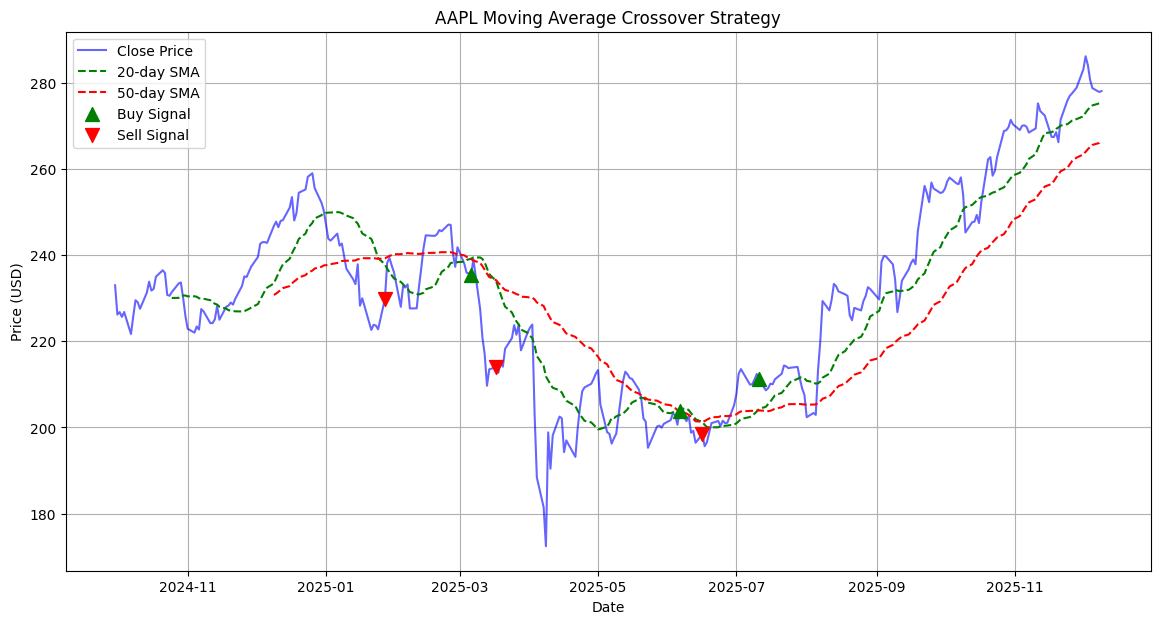


DataFrame with SMA and Signals:
           date   close    SMA_20    SMA_50  Signal
295  2025-12-03  284.15  273.7910  264.5880       0
296  2025-12-04  280.70  274.3190  265.1558       0
297  2025-12-05  278.78  274.7695  265.5940       0
298  2025-12-08  277.89  275.2405  266.0426       0
299  2025-12-09  278.09  275.6735  266.5158       0


In [ ]:
import matplotlib.pyplot as plt

# 1. Calculate 20-day and 50-day Simple Moving Averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# 2. Generate Buy/Sell Signals
df['Signal'] = 0 # 0 for no signal, 1 for buy, -1 for sell

# Identify potential crossovers
# When 20-day SMA crosses above 50-day SMA
df.loc[(df['SMA_20'] > df['SMA_50']) & (df['SMA_20'].shift(1) < df['SMA_50'].shift(1)), 'Signal'] = 1
# When 20-day SMA crosses below 50-day SMA
df.loc[(df['SMA_20'] < df['SMA_50']) & (df['SMA_20'].shift(1) > df['SMA_50'].shift(1)), 'Signal'] = -1

# Create columns for plotting buy and sell signals at the close price
df['Buy_Signal_Price'] = df.loc[df['Signal'] == 1, 'close']
df['Sell_Signal_Price'] = df.loc[df['Signal'] == -1, 'close']


# 3. Visualize the Results
plt.figure(figsize=(14, 7))

# Plot closing price
plt.plot(df['date'], df['close'], label='Close Price', color='blue', alpha=0.6)

# Plot moving averages
plt.plot(df['date'], df['SMA_20'], label='20-day SMA', color='green', linestyle='--')
plt.plot(df['date'], df['SMA_50'], label='50-day SMA', color='red', linestyle='--')

# Plot buy signals
plt.scatter(df['date'], df['Buy_Signal_Price'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
# Plot sell signals
plt.scatter(df['date'], df['Sell_Signal_Price'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)


plt.title('AAPL Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Display the head of the dataframe with new columns
print("\nDataFrame with SMA and Signals:")
print(df[['date', 'close', 'SMA_20', 'SMA_50', 'Signal']].tail())

Requesting historical volatility data...

Historical Data Head:
                       date      open      high       low     close  volume  \
0 2024-09-26 15:00:00-04:00  0.230339  0.230339  0.230339  0.230339     1.0   
1 2024-09-27 15:00:00-04:00  0.227180  0.227180  0.227180  0.227180     1.0   
2 2024-09-30 15:00:00-04:00  0.228307  0.228307  0.228307  0.228307     1.0   
3 2024-10-01 15:00:00-04:00  0.235482  0.235482  0.235482  0.235482     1.0   
4 2024-10-02 15:00:00-04:00  0.238276  0.238276  0.238276  0.238276     1.0   

    average  barCount  
0  0.230339         0  
1  0.227180         0  
2  0.228307         0  
3  0.235482         0  
4  0.238276         0  


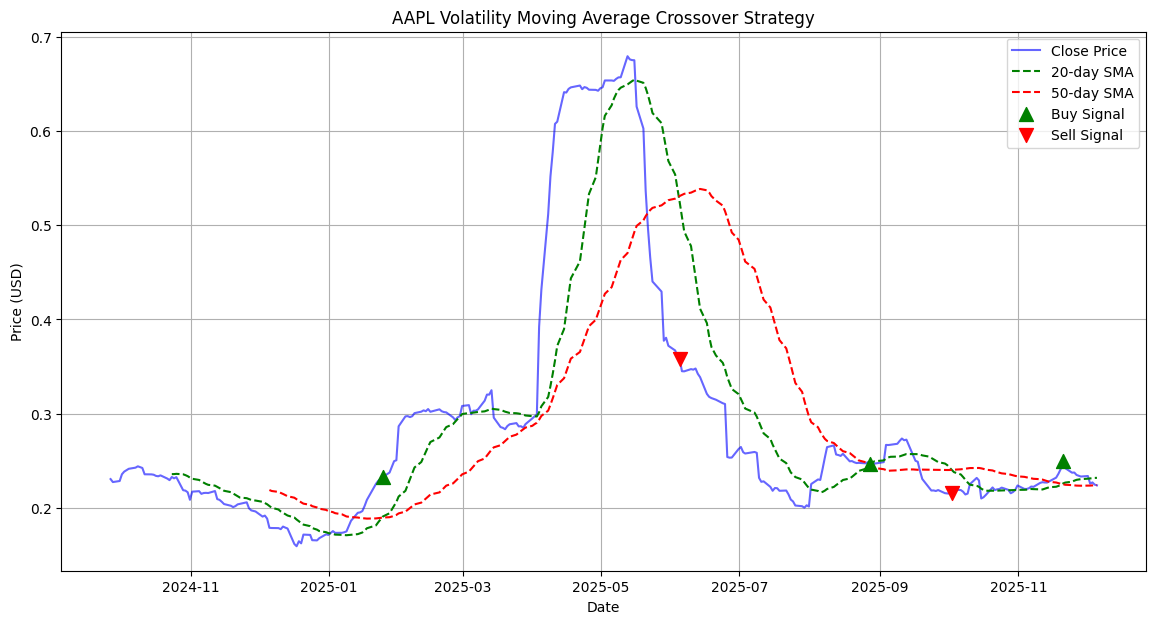


DataFrame with SMA and Signals:
                         date     close    SMA_20    SMA_50  Signal
295 2025-12-01 15:00:00-05:00  0.233609  0.230776  0.223371       0
296 2025-12-02 15:00:00-05:00  0.225513  0.231058  0.223456       0
297 2025-12-03 15:00:00-05:00  0.226815  0.231407  0.223628       0
298 2025-12-04 15:00:00-05:00  0.224434  0.231596  0.223751       0
299 2025-12-05 15:00:00-05:00  0.223735  0.231661  0.223872       0


In [ ]:
import matplotlib.pyplot as plt


print("Requesting historical volatility data...")
bars = ib.reqHistoricalData(
    contract,
    endDateTime='',        # Empty string = current time
    durationStr='300 D',     # 5 Days of data
    barSizeSetting='1 hour', # 1-day candles
    whatToShow='HISTORICAL_VOLATILITY',   # Use actual trade prices
    useRTH=True,           # Only include Regular Trading Hours
    formatDate=1
)

# 3. Convert to Pandas DataFrame for analysis

df_original = util.df(bars)

if df_original is not None:
    print("\nHistorical Data Head:")
    print(df_original.head())

    # Create a copy of the original DataFrame to work with
    df = df_original.copy()


# 1. Calculate 20-day and 50-day Simple Moving Averages
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# 2. Generate Buy/Sell Signals
df['Signal'] = 0 # 0 for no signal, 1 for buy, -1 for sell

# Identify potential crossovers
# When 20-day SMA crosses above 50-day SMA
df.loc[(df['SMA_20'] > df['SMA_50']) & (df['SMA_20'].shift(1) < df['SMA_50'].shift(1)), 'Signal'] = 1
# When 20-day SMA crosses below 50-day SMA
df.loc[(df['SMA_20'] < df['SMA_50']) & (df['SMA_20'].shift(1) > df['SMA_50'].shift(1)), 'Signal'] = -1

# Create columns for plotting buy and sell signals at the close price
df['Buy_Signal_Price'] = df.loc[df['Signal'] == 1, 'close']
df['Sell_Signal_Price'] = df.loc[df['Signal'] == -1, 'close']


# 3. Visualize the Results
plt.figure(figsize=(14, 7))

# Plot closing price
plt.plot(df['date'], df['close'], label='Close Price', color='blue', alpha=0.6)

# Plot moving averages
plt.plot(df['date'], df['SMA_20'], label='20-day SMA', color='green', linestyle='--')
plt.plot(df['date'], df['SMA_50'], label='50-day SMA', color='red', linestyle='--')

# Plot buy signals
plt.scatter(df['date'], df['Buy_Signal_Price'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
# Plot sell signals
plt.scatter(df['date'], df['Sell_Signal_Price'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)


plt.title('AAPL Volatility Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Display the head of the dataframe with new columns
print("\nDataFrame with SMA and Signals:")
print(df[['date', 'close', 'SMA_20', 'SMA_50', 'Signal']].tail())

Prompt: "Let's create a robust live monitoring system that will execute trades based on our signals. We need a function that checks for existing APPL positions before placeing new orders to avoid duplicates, uses a suitable interval for a daily strategy like hourly or daily checks rather than every minute, includes proper error handling for API issues, and logs all activities clearly. Then, in separate cell, show how we would start this monitoring system in a way that keeps our notebook responsive, such as using a background thread. Also, demonstrate how a user could safely stop the monitoring when desired. This real-world implementation will show how our strategy could be deployed as a practical automated trading system."

In [ ]:
import time
import threading
import datetime
import logging  

# Define a global stop event for the monitoring thread
stop_event = threading.Event()

class LiveTradingMonitor:
    def __init__(self, ib_connection, contract_obj, client_id, host, port, check_interval_seconds=3600):
        self.ib = ib_connection
        self.contract = contract_obj
        self.client_id = client_id
        self.host = host
        self.port = port
        self.check_interval_seconds = check_interval_seconds
        self.last_trade_action = None # To prevent rapid re-trading on same signal
        self.monitor_thread = None
        self.stop_event = stop_event # Use the global stop_event

    def _log(self, message):
        """Simple logging function."""
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"[{timestamp}] [MONITOR] {message}")

    def _ensure_connection(self):
        """Ensures IBKR connection is active."""
        if not self.ib.isConnected():
            self._log("IBKR is disconnected. Attempting to reconnect...")
            try:
                # Ensure the IB object is initialized correctly, or re-create it if needed
                # For simplicity here, we assume 'ib' is a global or passed object.
                # In a real system, you might pass connection details to a constructor and manage the IB object lifecycle.
                self.ib.connect(self.host, self.port, clientId=self.client_id)
                self._log(f"Successfully reconnected to IBKR on port {self.port} with ID {self.client_id}")
                self.ib.qualifyContracts(self.contract) # Re-qualify contract after reconnect
            except Exception as e:
                self._log(f"Failed to reconnect to IBKR: {e}")
                return False
        return True

    def _get_aapl_position(self):
        """Checks for existing AAPL position."""
        try:
            portfolio = self.ib.portfolio()
            for item in portfolio:
                if item.contract.symbol == self.contract.symbol and item.contract.exchange == self.contract.exchange:
                    return item.position
            return 0 # No position found
        except Exception as e:
            self._log(f"Error getting portfolio: {e}")
            return None # Indicate an error

    def _get_latest_data_and_signals(self):
        """Fetches latest historical data, calculates SMAs, and generates signal."""
        try:
            # Request enough data to calculate 50-day SMA, e.g., 60 days
            bars = self.ib.reqHistoricalData(
                self.contract,
                endDateTime='',
                durationStr='60 D', # 60 Days of data for SMAs
                barSizeSetting='1 day',
                whatToShow='TRADES',
                useRTH=True,
                formatDate=1
            )
            
            if not bars:
                self._log("No historical data received.")
                return None, None

            df_live = util.df(bars)
            if df_live is None or df_live.empty:
                self._log("Empty DataFrame from historical data.")
                return None, None
            
            # Ensure 'date' column is datetime if it's not already
            if 'date' in df_live.columns:
                df_live['date'] = pd.to_datetime(df_live['date'])
            df_live = df_live.set_index('date')

            # Calculate SMAs
            df_live['SMA_20'] = df_live['close'].rolling(window=20).mean()
            df_live['SMA_50'] = df_live['close'].rolling(window=50).mean()

            # We need at least two rows for SMA comparison to detect crossovers
            if len(df_live) < 2:
                self._log("Not enough data points for SMA calculation and signal generation.")
                return None, None

            # Get the latest two SMA values and their previous values
            latest_data = df_live.iloc[-1]
            prev_data = df_live.iloc[-2]

            sma_20_current = latest_data['SMA_20']
            sma_50_current = latest_data['SMA_50']
            sma_20_prev = prev_data['SMA_20']
            sma_50_prev = prev_data['SMA_50']

            current_close = latest_data['close']

            # Check for NaN values in SMAs, which can happen if not enough data
            if pd.isna(sma_20_current) or pd.isna(sma_50_current) or pd.isna(sma_20_prev) or pd.isna(sma_50_prev):
                self._log("SMAs are NaN due to insufficient data for the rolling window. Waiting for more data.")
                return 0, current_close # No signal if SMAs are not fully formed

            buy_signal = (sma_20_current > sma_50_current) and (sma_20_prev <= sma_50_prev)
            sell_signal = (sma_20_current < sma_50_current) and (sma_20_prev >= sma_50_prev)

            if buy_signal:
                self._log(f"BUY signal detected! SMA_20 ({sma_20_current:.2f}) crossed above SMA_50 ({sma_50_current:.2f}) at close {current_close:.2f}.")
                return 1, current_close # Buy signal
            elif sell_signal:
                self._log(f"SELL signal detected! SMA_20 ({sma_20_current:.2f}) crossed below SMA_50 ({sma_50_current:.2f}) at close {current_close:.2f}.")
                return -1, current_close # Sell signal
            else:
                self._log("No new trading signal detected.")
                return 0, current_close # Hold signal

        except Exception as e:
            self._log(f"Error fetching data or generating signals: {e}")
            return None, None

    def _place_order(self, action, quantity):
        """Places a market order."""
        if quantity <= 0:
            self._log(f"Cannot place {action} order with quantity {quantity}. Quantity must be positive.")
            return

        order_obj = MarketOrder(action, quantity)
        try:
            trade = self.ib.placeOrder(self.contract, order_obj)
            self._log(f"Order submitted: {action} {quantity} shares of {self.contract.symbol}. Status: {trade.orderStatus.status}")

            # Wait for order to fill or cancel
            # Using ib.sleep() to allow other IB-related events to process
            self.ib.sleep(2) # Give it a moment to update status
            
            # Simple polling for demonstration; for production, use trade.filledEvent and trade.cancelledEvent
            while not trade.isDone():
                self._log(f"Waiting for order {trade.order.orderId} to complete. Current status: {trade.orderStatus.status}...")
                self.ib.sleep(5) # Poll every 5 seconds

            final_status = trade.orderStatus.status
            if final_status == 'Filled':
                self._log(f"Order {trade.order.orderId} FILLED. Executed quantity: {trade.filled()} at average price: ${trade.avgFillPrice:.2f}")
            else:
                self._log(f"Order {trade.order.orderId} did not fill. Final status: {final_status}. Remaining: {trade.remaining()}.")
            return final_status
        except Exception as e:
            self._log(f"Error placing order: {e}")
            return "Error"

    def monitor_and_trade(self):
        """Main monitoring and trading logic for a single cycle."""
        self._log("Starting monitoring cycle...")

        if not self._ensure_connection():
            self._log("Failed to ensure IBKR connection. Skipping this cycle.")
            return

        current_position = self._get_aapl_position()
        if current_position is None:
            self._log("Could not retrieve current position. Skipping this cycle.")
            return

        self._log(f"Current {self.contract.symbol} position: {current_position} shares.")

        signal, _ = self._get_latest_data_and_signals()

        if signal is None:
            self._log("Failed to generate a signal. Skipping trade execution this cycle.")
            return

        # Avoid re-trading the same action on consecutive signals if no change in position
        if signal == 1 and self.last_trade_action == 'BUY' and current_position > 0:
            self._log("Buy signal detected, but already holding a position from a recent buy. No new action.")
            return
        if signal == -1 and self.last_trade_action == 'SELL' and current_position == 0:
            self._log("Sell signal detected, but no position to sell after a recent sell. No new action.")
            return

        if signal == 1: # Buy signal
            if current_position == 0:
                self._log("Executing BUY order.")
                order_status = self._place_order('BUY', 1) # Buy 1 share
                if order_status == 'Filled':
                    self.last_trade_action = 'BUY'
            else:
                self._log(f"Buy signal received, but already holding {current_position} shares. No action taken.")
        elif signal == -1: # Sell signal
            if current_position > 0:
                self._log(f"Executing SELL order to close position of {current_position} shares.")
                order_status = self._place_order('SELL', current_position) # Sell all shares
                if order_status == 'Filled':
                    self.last_trade_action = 'SELL'
            else:
                self._log("Sell signal received, but no shares to sell. No action taken.")
        else:
            self._log("No trade action based on current signal.")

    def run_monitoring_loop(self):
        """Starts the continuous monitoring loop in a thread."""
        self._log("Starting live trading monitor thread.")
        self.stop_event.clear() # Ensure stop event is clear before starting

        while not self.stop_event.is_set():
            self.monitor_and_trade()
            if not self.stop_event.is_set(): # Check again before sleeping
                self._log(f"Next check in {self.check_interval_seconds / 60:.0f} minutes...")
                self.stop_event.wait(self.check_interval_seconds) # Wait with the event, allowing it to be stopped

        self._log("Live trading monitor thread stopped.")
        # Optionally disconnect IB here if this is the only thing using it
        # if self.ib.isConnected():
        #     self.ib.disconnect()
        #     self._log("Disconnected IBKR.")

    def start(self):
        """Starts the monitoring in a background thread."""
        if self.monitor_thread is None or not self.monitor_thread.is_alive():
            self.monitor_thread = threading.Thread(target=self.run_monitoring_loop, daemon=True)
            self.monitor_thread.start()
            self._log("Monitor started in a background thread.")
        else:
            self._log("Monitor is already running.")

    def stop(self):
        """Safely stops the monitoring thread."""
        if self.monitor_thread and self.monitor_thread.is_alive():
            self._log("Signaling monitor thread to stop...")
            self.stop_event.set() # Set the event to signal the thread to stop
            self.monitor_thread.join(timeout=self.check_interval_seconds + 5) # Wait for the thread to finish gracefully
            if self.monitor_thread.is_alive():
                self._log("Monitor thread did not stop gracefully.")
            else:
                self._log("Monitor thread stopped successfully.")
            self.monitor_thread = None
        else:
            self._log("Monitor is not running.")


In [ ]:
live_trading_monitor = LiveTradingMonitor(
    ib_connection=ib,
    contract_obj=contract,
    client_id=IB_DUMMY_ID,
    host=IB_HOST,
    port=IB_PORT,
    check_interval_seconds=3600 # Check every hour
)
# live_trading_monitor.start()

[2025-12-05 20:49:07] [MONITOR] Starting live trading monitor thread.[2025-12-05 20:49:07] [MONITOR] Monitor started in a background thread.

[2025-12-05 20:49:07] [MONITOR] Starting monitoring cycle...
[2025-12-05 20:49:07] [MONITOR] Current AAPL position: 0 shares.


[2025-12-05 20:50:07] [MONITOR] No new trading signal detected.
[2025-12-05 20:50:07] [MONITOR] No trade action based on current signal.
[2025-12-05 20:50:07] [MONITOR] Live trading monitor thread stopped.


In [ ]:
# live_trading_monitor.stop()

[2025-12-05 20:49:24] [MONITOR] Signaling monitor thread to stop...
[2025-12-05 20:50:07] [MONITOR] Monitor thread stopped successfully.
